In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore') # to ignore some depreciation errors

df = pd.read_csv('liverpatientsdataset.csv', nrows=500)

targetVar = 'result'
# obviously, result is the target variable and we'll use this below

# converting gender col into a 0 or 1 bool
le = LabelEncoder()
df['GENDER'] = le.fit_transform(df['gender'])

# Convert numerical columns to numeric data type
numerical_columns = df.select_dtypes(include=[np.number]).columns
df[numerical_columns] = df[numerical_columns].apply(pd.to_numeric, errors='coerce')

# Dropping non-numeric columns
df_numeric = df[numerical_columns].dropna(axis=1)

# correlation between each feature and the target variable and sort by desc
correlation_with_target = df_numeric.corrwith(df_numeric[targetVar])
sorted_features = correlation_with_target.abs().sort_values(ascending=False)

# Initialize selected features list with the first feature (highest correlation)
selected_features = [sorted_features.index[0]]

# function to calculate the merit of a feature given the currently selected features
def calculate_merit(feature, selected_features):
    correlation_with_target = df_numeric[selected_features + [feature]].corrwith(df_numeric[targetVar])
    correlation_sum = correlation_with_target.abs().sum()
    redundancy = df_numeric[selected_features].corr().sum().sum()  # Total correlation among selected features
    merit = correlation_sum / np.sqrt(1 + redundancy)
    return merit

# selecting feautures with highest merit until negative merit
for feature in sorted_features.index[1:]:
    merit = calculate_merit(feature, selected_features)
    if merit > 0:
        selected_features.append(feature)
    else:
        break

# Selected features
print("Selected features based on CFS:")
print(selected_features)

Selected features based on CFS:
['result', 'age', 'GENDER']


In [ ]:
import numpy as np
import pandas as pd
import json

def calculate_redundancy(df, feature1, feature2):
    corr = np.abs(df[[feature1, feature2]].corr().iloc[0, 1])
    return corr

def calculate_relevance(df, feature, targetVar):
    return np.abs(df[feature].corr(df[targetVar]))

def calculate_merit(df, feature, targetVar, selected_features):
    relevance = calculate_relevance(df, feature, targetVar)
    redundancy = sum(calculate_redundancy(df, feature, selected_feature) for selected_feature in selected_features)
    return relevance - redundancy

# FCBF feature selection

# F-score and p-values - for each feature
F_scores, _ = f_classif(df_numeric.drop(columns=[targetVar]), df_numeric[targetVar])

feature_stats = pd.DataFrame({'Feature': df_numeric.drop(columns=[targetVar]).columns, 'F_score': F_scores})
feature_stats = feature_stats.sort_values(by='F_score', ascending=False)

selected_features = set()
selected_features.add(feature_stats.iloc[0]['Feature'])
for _, row in feature_stats.iloc[1:].iterrows():
    feature = row['Feature']
    merit = calculate_merit(df_numeric, feature, targetVar, selected_features)
    if merit > 0:
        selected_features.add(feature)
    else:
        break

print("features selected based on Fast Correlation Based Feature Selection (FCBF): ")
print(selected_features)

features selected based on Fast Correlation Based Feature Selection (FCBF): 
{'GENDER', 'age'}


In [ ]:
def calculate_silhouette_score(df, selected_features):
    if len(selected_features) == 1:
        return 1.0  # always 1 for a single feauture
    else:
        data_subset = df[selected_features]
        kmeans = KMeans(n_clusters=len(selected_features)).fit(data_subset)
        labels = kmeans.labels_
        return silhouette_score(data_subset, labels)

# FAST feature selection
selected_features = [targetVar]
best_score = 0.0

while True:
    best_feature = None
    best_silhouette_score = -1

    for feature in df_numeric.columns:
        if feature not in selected_features:
            current_selected_features = selected_features + [feature]
            silhouette_score_val = calculate_silhouette_score(df_numeric, current_selected_features)
            if silhouette_score_val > best_silhouette_score:
                best_silhouette_score = silhouette_score_val
                best_feature = feature

    if best_feature is None:
        break

    # best feature -> [selected features]
    selected_features.append(best_feature)

print("features selected based on Fast Clustering based Feature Selection (FAST): ")
print(selected_features)

features selected based on Fast Clustering based Feature Selection (FAST): 
['result', 'GENDER', 'age']


In [ ]:
import numpy as np
import pandas as pd
import json

def relief(df, target_column, num_neighbors=5, num_iterations=100):
  # Initialize feature weights
  feature_weights = {feature: 0 for feature in df.columns if feature != target_column}

  # Separate instances by class (with handling for empty classes)
  class_instances = {}
  for class_label in df[target_column].unique():
    if class_label in df[target_column].values:  # Check if class_label exists
      class_instances[class_label] = df[df[target_column] == class_label].drop(columns=[target_column])

  # Perform Relief algorithm
  for _ in range(num_iterations):
    # Randomly select an instance
    instance_index = np.random.randint(0, len(df))
    instance = df.iloc[instance_index]
    target_class = instance[target_column]

    # Find nearest instance of the same class (handle empty case)
    same_class_instances = class_instances.get(target_class)  # Use get() for potential None value
    if same_class_instances is not None:  # Check if instances exist for this class
      same_class_distances = ((same_class_instances - instance) ** 2).sum(axis=1)
      nearest_same_class_index = same_class_distances.idxmin()
      nearest_same_class_instance = same_class_instances.loc[nearest_same_class_index]

    # Find nearest instances of different classes (handle empty cases)
    other_class_distances = {}
    for class_label, instances in class_instances.items():
      if class_label != target_class and len(instances) > 0:  # Check for different class and non-empty instances
        distances = ((instances - instance) ** 2).sum(axis=1)
        other_class_distances[class_label] = distances.min()

    # Update feature weights (handle cases where nearest instances might be None)
    for feature in feature_weights:
      difference_same = 0
      if same_class_instances is not None:  # Check for same class instances
        difference_same = abs(instance[feature] - nearest_same_class_instance[feature])
      feature_weights[feature] -= difference_same / num_iterations

      for class_label, distance in other_class_distances.items():
        nearest_other_class_instance = None
        if len(class_instances[class_label]) > 0:  # Check for instances in other class
          nearest_other_class_instance = class_instances[class_label].loc[distances.idxmin()]
        difference_other = 0
        if nearest_other_class_instance is not None:  # Check for nearest instance
          difference_other = abs(instance[feature] - nearest_other_class_instance[feature])
        feature_weights[feature] += difference_other / (num_neighbors * num_iterations)

    # Normalize feature weights
    total_weight = sum(abs(weight) for weight in feature_weights.values())
    normalized_weights = {feature: abs(weight) / total_weight for feature, weight in feature_weights.items()}

    # Sort features by their weights
    sorted_features = sorted(normalized_weights.items(), key=lambda x: x[1], reverse=True)

    return [feature for feature, _ in sorted_features]

# Perform Relief feature selection
selected_features = relief(df_numeric, targetVar)

# Print the selected features
print("Top 2 features based on Relief algorithm: ")
print(selected_features)


Top 2 features based on Relief algorithm: 
['age', 'GENDER']


Top 3 selected features:
age
gender
grossBR


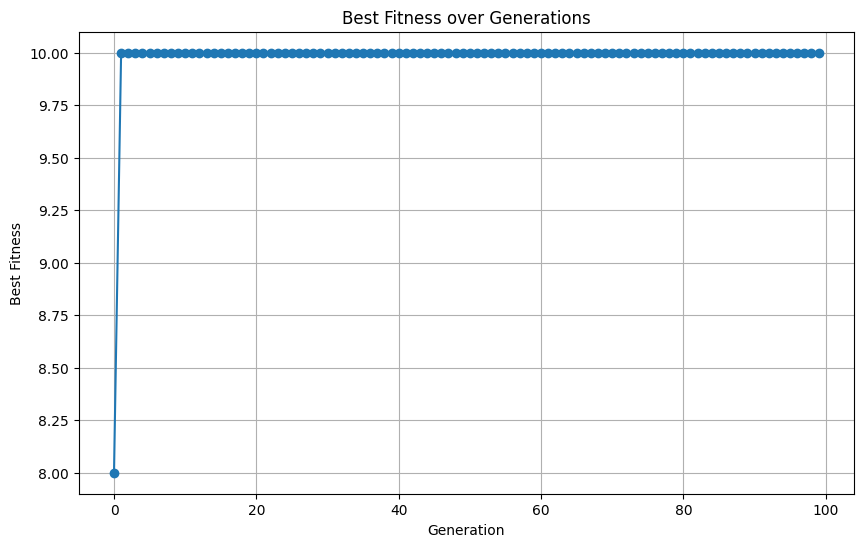

In [ ]:
# Genetic Algorithm based feature selection
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Load the dataset
data = pd.read_csv('/content/liverpatientsdataset.csv')

# Separate features and target
X = data.drop(columns=['result'])  # Features
y = data['result']  # Target


def fitness(individual):
  return np.sum(individual)

# Define the genetic algorithm parameters
population_size = 100
generations = 100
mutation_rate = 0.1
crossover_rate = 0.7

# Initialize the population
population = np.random.randint(2, size=(population_size, len(X.columns)))

# Track the best fitness over generations
best_fitness = []

# Perform the genetic algorithm
for generation in range(generations):
  # Calculate the fitness of each individual
  fitness_values = np.array([fitness(individual) for individual in population])

  # Select the fittest individuals for reproduction
  parents = np.argsort(fitness_values)[-int(population_size / 2):]

  # Create the next generation
  next_generation = np.empty_like(population)
  for i in range(int(population_size / 2)):
    # Select two parents
    parent1 = population[parents[i]]
    parent2 = population[parents[np.random.randint(0, len(parents))]]

    # Perform crossover
    if np.random.rand() < crossover_rate:
      crossover_point = np.random.randint(1, len(parent1))
      next_generation[i] = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
      next_generation[i + int(population_size / 2)] = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    else:
      next_generation[i] = parent1
      next_generation[i + int(population_size / 2)] = parent2

  # Perform mutation
  for i in range(len(next_generation)):
    if np.random.rand() < mutation_rate:
      mutation_point = np.random.randint(0, len(next_generation[i]))
      next_generation[i][mutation_point] = 1 if next_generation[i][mutation_point] == 0 else 0

  # Update the population
  population = next_generation

  # Track the best fitness
  best_fitness.append(np.max(fitness_values))

# Print the best individual
best_individual = population[np.argmax(fitness_values)]
selected_features = X.columns[best_individual == 1]

# Print the top 3 selected features
print("Top 3 selected features:")
for feature in selected_features[:3]:
  print(feature)


# Plot the best fitness over generations
plt.figure(figsize=(10, 6))
plt.plot(range(generations), best_fitness, marker='o', linestyle='-')
plt.title('Best Fitness over Generations')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.grid(True)
plt.show()



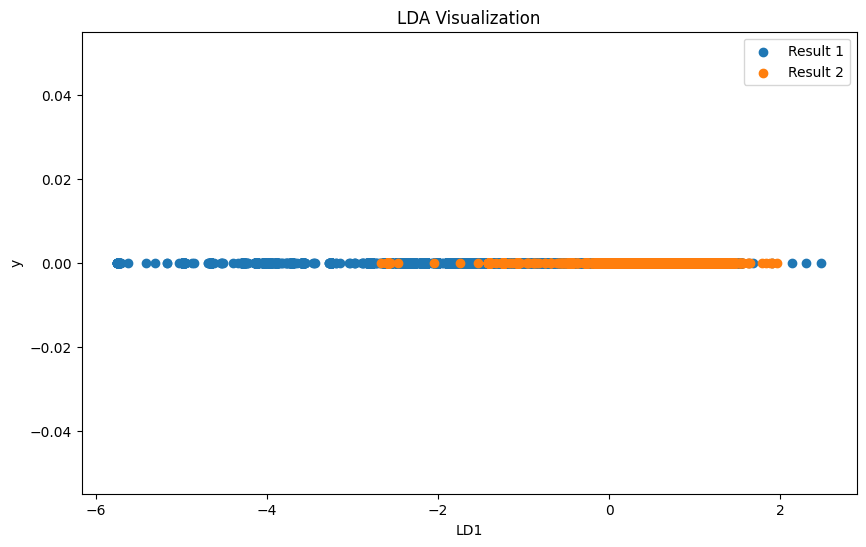

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Load the dataset
data = pd.read_csv('/content/liverpatientsdataset.csv')

# Separate features and target
X = data.drop(columns=['result'])  # Features
y = data['result']  # Target

# Encode categorical variables
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['gender'])], remainder='passthrough')
X_encoded = ct.fit_transform(X)

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_encoded)

# Perform LDA
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X_imputed, y)

# Plot
plt.figure(figsize=(10, 6))
for label in [1, 2]:
    plt.scatter(X_lda[y == label, 0], [0] * sum(y == label), label=f'Result {label}')  # Only plot LD1

plt.xlabel('LD1')
plt.ylabel('y')
plt.legend()
plt.title('LDA Visualization')
plt.show()


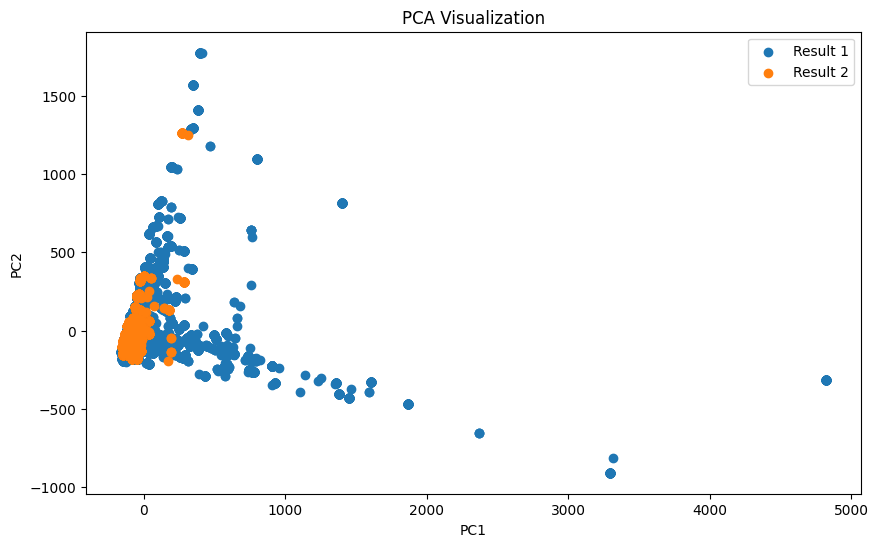

In [ ]:
#  PCA  with visualization

# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/liverpatientsdataset.csv')

# Separate features and target
X = data.drop(columns=['result'])  # Features
y = data['result']  # Target

# Encode categorical variables
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['gender'])], remainder='passthrough')
X_encoded = ct.fit_transform(X)

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_encoded)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_imputed)

# Plot
plt.figure(figsize=(10, 6))
for label in [1, 2]:
    plt.scatter(X_pca[y == label, 0], X_pca[y == label, 1], label=f'Result {label}')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('PCA Visualization')
plt.show()


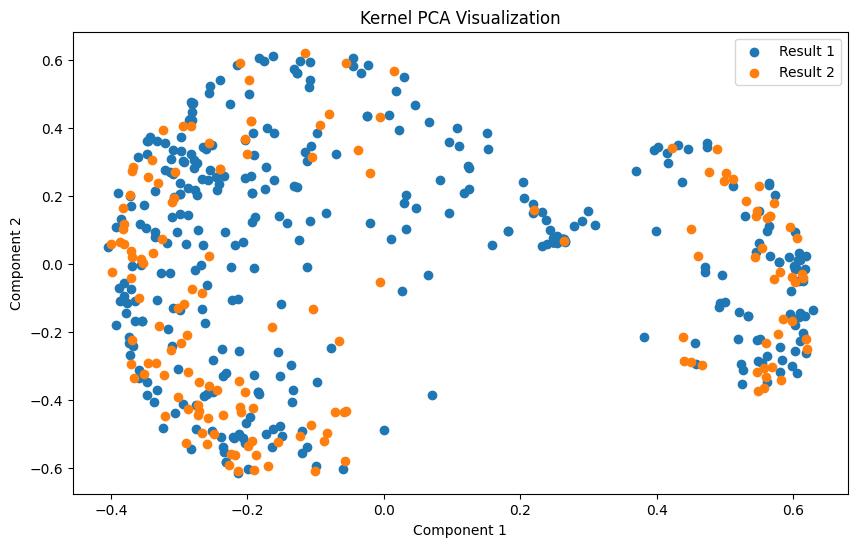

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Load the dataset
data = pd.read_csv('/content/liverpatientsdataset.csv',nrows=500)

# Separate features and target
X = data.drop(columns=['result'])  # Features
y = data['result']  # Target

# Preprocess categorical variables and handle missing values
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['gender'])], remainder='passthrough')
X_encoded = ct.fit_transform(X)

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_encoded)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Perform Kernel PCA
kpca = KernelPCA(n_components=2, kernel='rbf')  # You can choose different kernels: 'linear', 'poly', 'rbf', 'sigmoid', etc.
X_kpca = kpca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 6))
for label in [1, 2]:
    plt.scatter(X_kpca[y == label, 0], X_kpca[y == label, 1], label=f'Result {label}')

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.title('Kernel PCA Visualization')
plt.show()


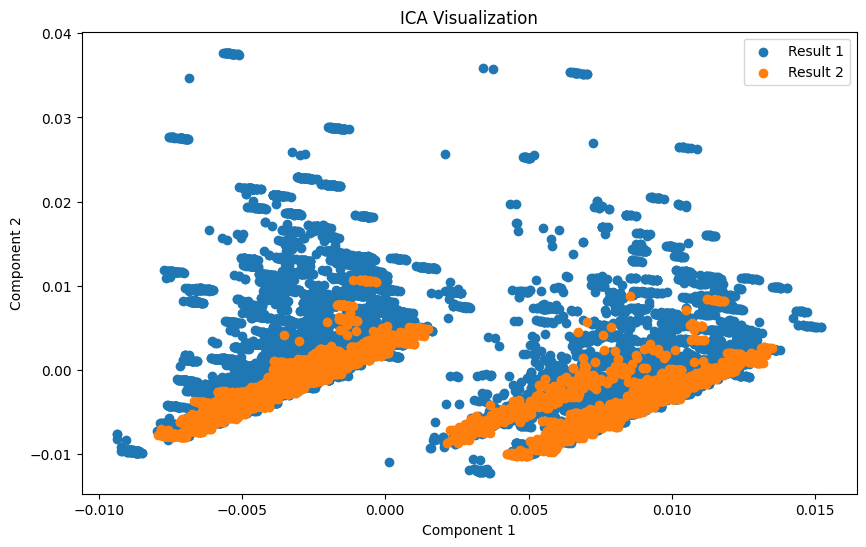

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Load the dataset
data = pd.read_csv('/content/liverpatientsdataset.csv')

# Separate features and target
X = data.drop(columns=['result'])  # Features
y = data['result']  # Target

# Preprocess categorical variables and handle missing values
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['gender'])], remainder='passthrough')
X_encoded = ct.fit_transform(X)

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_encoded)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Perform ICA
ica = FastICA(n_components=2)
X_ica = ica.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 6))
for label in [1, 2]:
    plt.scatter(X_ica[y == label, 0], X_ica[y == label, 1], label=f'Result {label}')

plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.title('ICA Visualization')
plt.show()
